<a href="https://colab.research.google.com/github/FilippoCasellini/2025_ML_EES/blob/main/S1_2_Training_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# (Exercises) Training Models

This week's notebook is based off of the exercises in Chapter 4 of Géron's book.

## Notebook Setup
Let's begin like in the last notebook: importing a few common modules, ensuring MatplotLib plots figures inline and preparing a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so once again we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

You don't need to worry about understanding everything that is written in this section.

In [1]:
#@title  Run this cell for preliminary requirements. Double click it if you want to check out the source :)

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To make this notebook's output stable across runs
rnd_seed = 42
rnd_gen = np.random.default_rng(rnd_seed)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

#Ensure the palmerspenguins dataset is installed
%pip install palmerpenguins --quiet

 **Data Setup**

In this notebook we will be working with the [*Palmer Penguins dataset*](https://allisonhorst.github.io/palmerpenguins/articles/intro.html). Each entry in the dataset includes the penguin's species, island, sex, flipper length, body mass, bill length, bill depth, and the year the study was carried out. Let's take a moment and observe our subjects! <br>

<center> <font size=+30>🐧</font><br>
In order: Adélie (Pygoscelis adeliae),  Chinstrap (Pygoscelis antarcticus), and Gentoo (Pygoscelis papua) penguins <br>

<img src='https://unils-my.sharepoint.com/:i:/g/personal/tom_beucler_unil_ch/EY2OrrxSOSlIiQZ4FQ719YAB80_joiBs9e58jtlSf4H_eQ?download=1' width=32% >
<img src='https://unils-my.sharepoint.com/:i:/g/personal/tom_beucler_unil_ch/EVuvzIGBs_JGihnUSWBGQ1IBjv-ZtUDUo7cXeWtyx9g6Og?download=1' width=32%></img>
<img src='https://unils-my.sharepoint.com/:i:/g/personal/tom_beucler_unil_ch/EXrZM1rJOXRLlmdPTm-BP2gBCgs1qfQiknp29lX4p_7GtQ?download=1' width=32%></img>

</center>

As you can imagine, this dataset is normally used to train *multiclass*/*multinomial* classification algorithms and not *binary* classification algorithms, since there *are* more than 2 classes.

"*Three classes, even!*" - an observant TA

For this exercise, however, we will implement the binary classification algorithm referred to as the *logistic regression* algorithm (also called logit regression).

In [2]:
# Let's load the Palmer Penguins Dataset!
from palmerpenguins import load_penguins
data = load_penguins()

Like with the Titanic dataset in the previous notebook, the data here is loaded as a Pandas DataFrame. Feel free to play around with it in the cell below!

In [3]:
# The following code will make the dataframe be shown in an interactive table
# inside of Google colab. Use data.head(5) if you're running this locally

from google.colab import data_table
data_table.enable_dataframe_formatter()

data

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


As we mentioned before, there are three species of penguin in the dataset. However, today we'll be implementing a _binary classification algorithm_, which means we need to have exactly two target classes! Let's go ahead and filter the data so that we keep the Adelie and Gentoo species.

In [4]:
# We define the species that we're interested in
species = ['Adelie','Gentoo']

# And use the .loc method in Pandas to keep only the two species mentioned above
data = data.loc[data['species'].isin(species)]

In [5]:
#@title Today, we'll be learning to classify the penguins based on the length and depth of their bills.  Run the cell and take a look at the data! 🔎

import plotly.express as px

# Dimensions for interactive plot
dims = ['bill_length_mm', 'bill_depth_mm']
colors = ['orange','black','lightseagreen']

fig = px.scatter_matrix(
                        data,
                        dimensions=dims,
                        color="species",
                        color_discrete_sequence = colors
                        )

fig.show()

We now have a dataframe with all the information that we need. Let's go ahead and extract the bill length and depth to use as input data, storing it in $x$.
Then we'll store the labels (i.e., the _targets_) in $y$.

## Q1) Extract the bill length and bill depth to use as the input vector $x$, and store the label (i.e., the target data) in $y$


In [6]:
#@title Hints - Data Loading and Filtering

'''
Loading data into X:

You can access multiple columns of a pandas dataframe using a list! The snippet
below will return the species and island associated with each penguin in the
database.

In the cell below, you want to load the bill length and bull depth columns.
Make sure you use the right column name! Copy it from the dataframe view we
printed before, and make sure there aren't any extra spaces
''';
data[['species','island']];

'''
Finding the NaN row indices

Pandas has a built-in function to determine if the value is a NaN (Not a Number)
value.

mydata.notna() will return True wherever the data isn't a NaN value, but we need
to check if each row has _any_ NaN values - that's what the _all(axis=1)_ does.
''';

In [8]:
# Load the bill length and depth into X
X = data['bill_length_mm','bill_depth_mm']

# Find out the rows where you don't have an valid input (i.e., rows with a nan value)
indices = X.notna().all(axis=1)

# Filter out the datapoints using the indices we found
X = X[indices]

# We'll also normalize the data using the mean and standard deviation
X = (X - X.mean())/X.std()

In [9]:
# Let's take a look at the input dataset - if you did everything right, you'll
# have 274 entries and printing out x.shape will return (274,2)
print(X.shape)

(274, 2)


We have our input data, but we need a target to predict. We previously filtered the data to only include Adélie and Gentoo penguins, but we still have them as strings! Let's convert them to a binary representation (i.e., 0 or 1). Make sure you have the same penguins as in your input!

## **Q2) Convert the species label to a binary classification, and filter the target data to match the input data.**

In [10]:
#@title Hints - Boolean Representation & Type Conversion

'''
Boolean Representation

You can access the species data by calling data['species']

== is the operator that lets you check if the data is equal to another value

data['island'] == Torgesen
will return True for each row if the penguin was studied in Torgesen, and False
if it was studied in another island
''';

'''
Type Conversion

Pandas dataframes include a method to change the type of the data being called.

data['bill_length_mm'].astype(int) will return the bill length data as integers
''';

In [11]:
# Convert species data into boolean form by checking if the species is Adélie
y = (data['species'] == 'Adélie')

# Filter out the points for which we have NaN values. Reuse the indices from Q1!
y = y[indices]

# Convert the boolean data into an integer
y = y.astype(int)

In [12]:
# Print out y! If everything is implemented correctly, you should see a panda
# series full of ones and zeroes with 274 rows
print(y)

0      0
1      0
2      0
4      0
5      0
      ..
270    0
272    0
273    0
274    0
275    0
Name: species, Length: 274, dtype: int64


We now have a set of binary classification data we can use to train an algorithm.

As we saw during our reading, we need to define three things in order to train our algorithm:
> $\cdot$ the type of algorithm we will train, \\
> $\cdot$ the cost function (which will tell us how close our prediction is to the truth), and \\
> $\cdot$ a method for updating the parameters in our model according to the value of the cost function (e.g., the gradient descent method).

Let's begin by defining the type of algorithm we will use. We will train a logistic regression model to differentiate between two classes. A reminder of how the logistic regression algorithm works is given below.
<br><br><br>
The logistic regression algorithm will thus take an input $t$ that is a linear combination of the features:

<a name="logit"></a>

<center> $t_{\small{n}} = \beta_{\small{0}} + \beta_{\small{1}} \cdot X_{1,n} + \beta_{\small{2}} \cdot X_{2,n}$ </center>

where
* $n$ is the ID of the sample
* $X_{\small{0}}$ represents the bill length
* $X_{\small{1}}$ represents the bill width

This input is then fed into the logistic function, $\sigma$:
\begin{align}
\sigma: t\mapsto \dfrac{1}{1+e^ {-t}}
\end{align}

Let's define the logistic function for later use.

## **Q3) Define the logistic function**

In [13]:
#@title Hint - Exponential Function
'''
Numpy includes the exponential function in its library as numpy.exp
https://numpy.org/doc/stable/reference/generated/numpy.exp.html
''';

np.exp(2);

In [15]:
def logistic(in_val):
    # Return the value of the logistic function
    out_value = 1/(1+np.exp(-in_val))
    return out_value

Now that the logistic function has been defined, we can plot it (this will help us remember what it looks like!) Run the code below - you won't have to fill anything in for this one 😀 But feel free to show the code and read through it - some of the functions used can be helpful to you down the line!

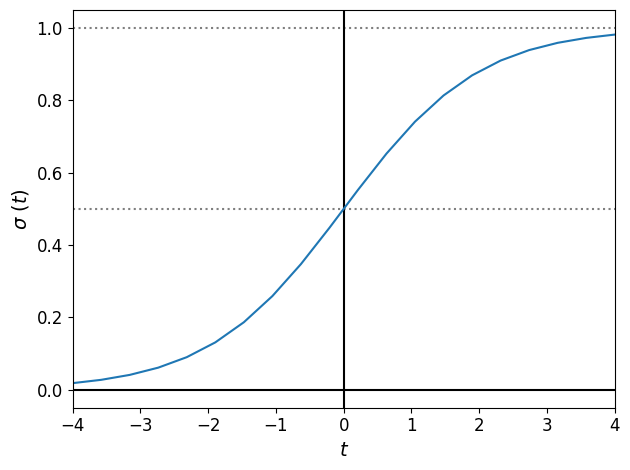

In [16]:
#@title Run this to plot the logistic function!
# Let's generate an array of 20 points with values from -4 to +4
t = np.linspace(-4,4,20)

# Initiate a figure and axes object using matplotlib
fig, ax = plt.subplots()

# Draw the X and Y axes
ax.axvline(0, c='black', alpha=1)
ax.axhline(0, c='black', alpha=1)

# Draw the threshold line (y_val=0,5) and asymptote (y=1)
[ax.axhline(y_val, c='black', alpha=0.5, linestyle='dotted') for y_val in (0.5,1)]

# Scale things to make the graph look nicer
plt.autoscale(axis='x', tight=True)

# Plot the logistic function. X values from the t vector, y values from logistic(t)
ax.plot(t, logistic(t));
ax.set_xlabel('$t$')
ax.set_ylabel('$\\sigma\\  \\left(t\\right)$')
fig.tight_layout()

With the logistic function, we define inputs resulting in $\sigma\geq0.5$ as belonging to the ***one*** class, and any value below that is considered to belong to the ***zero*** class.

We now have a function which lets us map the value of the bill length and width to the class to which the observation belongs (i.e., whether the length and width correspond to Adélie or Gentoo penguins). However, there is a parameter vector **$\theta$** with a number of parameters that we do not have a value for: <br> $\theta = [ \beta_{\small{0}}, \beta_{\small{1}}$, $\beta_{\small{2}} ]$

## **Q4) Set up an array of random numbers between 0 and 1 representing the $\theta$ vector.**


In [17]:
#@title Hints: Random Number Generation
'''
Random Number Generation
Use `rnd_gen`! If you're not sure how to use it, consult the `default_rng`
documentation at this address:
https://numpy.org/doc/stable/reference/random/generator.html

For instance, you may use the `random` method of `rnd_gen`.*
''';

'''
The theta array should have 3 elements in it!
''';

In [18]:
#@title Hint: Code Snipppet
'''
rnd_gen.random((___,)) # length of array
''';

In [19]:
theta = rnd_gen.random((3,))

In order to determine whether a set of $\beta$ values is better than the other, we need to quantify well the values are able to predict the class. This is where the cost function comes in.

The cost function, $c$, will return a value close to zero when the prediction, $\hat{p}$, is correct and a large value when it is wrong. In a binary classification problem, we can use the log loss function. For a single prediction and truth value, it is given by:
\begin{align}
        \text{c}(\hat{p},y) = \left\{
        \begin{array}{cl}
        -\log(\hat{p})& \text{if}\; y=1\\
        -\log(1-\hat{p}) & \text{if}\; y=0
        \end{array}
        \right.
    \end{align}

However, we want to apply the cost function to an n-dimensional set of predictions and truth values. Thankfully, we can find the average value of the log loss function $J$ for an an-dimensional set of $\hat{y}$ & $y$ as follows:

\begin{align}
        \text{J}(\mathbf{\hat{p}},y) = - \dfrac{1}{n} \sum_{i=1}^{n}
        \left[ y_i\cdot \log\left( \hat{p}_i \right) \right] +
        \left[ \left( 1 - y_i \right) \cdot \log\left( 1-\hat{p}_i \right) \right]
    \end{align}

We now have a formula that can be used to calculate the average cost over the training set of data.

Now let's code 💻


## **Q5) Define a log_loss function that takes in an arbitrarily large set of prediction and truths**

*Hint 1: You need to encode the function $J$ above, for which Numpy's functions may be quite convenient (e.g., [`log`](https://numpy.org/doc/stable/reference/generated/numpy.log.html), [`mean`](https://numpy.org/doc/stable/reference/generated/numpy.mean.html), etc.)*

*Hint 2: Asserting the dimensions of the vector is a good way to check that your function is working correctly. [Here's a tutorial on how to use `assert`](https://swcarpentry.github.io/python-novice-inflammation/10-defensive/index.html#assertions). For instance, to assert that two vectors `X` and `y` have the same dimension, you may use:*
```
assert X.shape==y.shape
```

In [20]:
#@title Hint: Example code snippet
'''
J_vector  = -(y * np.log(p_hat + epsilon) + (1-y) * np.log(1-y_hat))
J.mean()
''';

In [22]:
def log_loss(p_hat, y, epsilon=1e-7):

  # Begin by calculating the two possibilities for the cost function, i.e.
  # 1: -log(p_hat + epsilon), and 2: -log(1- p_hat). We added an epsilon term
  # to -log(p_hat) because we can run into mathematical problems if p_hat = 0.
  term_1 = -np.log( p_hat + epsilon )
  term_2 = -np.log( 1 - p_hat )

  # We can almost calculate J! We'll need to 1) multiply term_1 by y, and
  # 2) multiply term_2 by (1-y). We then add the new terms together.
  # Calculate the value of the cost function (i.e., what's inside the brackets)
  inside_brackets = (y) * term_1 + ( 1 - y ) * term_2

  #Verify the shape of inside_brackets.
  print(f'The size of the term inside the brackets is {inside_brackets.shape}')

  # You should have a cost value for each one of your predictions. We won't
  # use the individual values, though. We'll aggregate the information from
  # all our predictions by calculating the mean! (i.e., 1/n_terms * terms_sum)
  # This single value is J
  J = inside_brackets.mean()

  return J

We now have a way of quantifying how good our predictions are. The final thing needed for us to train our algorithm is figuring out a way to update the parameters in a way that improves the average quality of our predictions.

<br><br>**Warning**: we'll go into a bit of math below <br><br>

Let's look at the change in a single parameter within $\theta$: $\beta_1$ (given $X_{1,i} = X_1$, $\;\hat{p}_{i} = \hat{p}$, $\;y_{i} = y$). If we want to know what the effect of changing the value of $\beta_1$ will have on the log loss function we can find this with the partial derivative:
<center>$
        \dfrac{\partial J}{\partial \beta_1}
$</center>

This may not seem very helpful by itself - after all, $\beta_1$ isn't even in the expression of $J$. But if we use the chain rule, we can rewrite the expression as:
<center>
        $\dfrac{\partial J}{\partial \hat{p}} \cdot
        \dfrac{\partial \hat{p}}{\partial \theta} \cdot
        \dfrac{\partial \theta}{\partial \beta_1}$
</center>

We'll spare you the math (feel free to verify it youself, however!):

<center>$\dfrac{\partial J}{\partial \hat{p}} =  \dfrac{\hat{p} - y}{\hat{p}(1-\hat{p})}, \quad
        \dfrac{\partial \hat{p}}{\partial \theta} = \hat{p} (1-\hat{p}), \quad
        \dfrac{\partial \theta}{\partial \beta_1} = X_1 $
</center>

and thus
<center>$
        \dfrac{\partial J}{\partial \beta_1} = (\hat{p} - y) \cdot X_1
$</center>

We can calculate the partial derivative for each parameter in $\theta$ which, as you may have realized, is simply the $\theta$ gradient of $J$: $\nabla_{\theta}(J)$

With all of this information, we can now write $\nabla_{\theta} J$ in terms of the error, the feature vector, and the number of samples we're training on!

<a name="grad_eq"></a>

<center>$\nabla_{\mathbf{\theta}^{(k)}} \, J(\mathbf{\theta^{(k)}}) = \dfrac{1}{n} \sum\limits_{i=1}^{n}{ \left ( \hat{p}^{(k)}_{i} - y_{i} \right ) \mathbf{X}_{i}}$</center>

Note that here $k$ represents the iteration of the parameters we are currently on.

We now have a gradient we can calculate and use in the batch gradient descent method! The updated parameters will thus be:

<a name="grad_descent"></a>

\begin{align}
{\mathbf{\theta}^{(k+1)}} = {\mathbf{\theta}^{(k)}} - \eta\,\nabla_{\theta^{(k)}}J(\theta^{(k)})
\end{align}

Where $\eta$ is the learning rate parameter. It's also worth pointing out that $\;\hat{p}^{(k)}_i = \sigma\left(\theta^{(k)}, X_i\right) $

In order to easily calculate the input to the logistic regression, we'll multiply the $\theta$ vector with the X data, and as we have a non-zero bias  $\beta_0$ we'd like to have an X matrix whose first column is filled with ones.

\begin{align}
    X_{\small{with\ bias}} = \begin{pmatrix}
        1 & X_{1,0} & X_{2,0}\\
        1 & X_{1,1} & X_{2,1}\\
        &...&\\
        1 & X_{1,n} & X_{2,n}
        \end{pmatrix}
\end{align}
<br>


## **Q6) Prepare the `X_with_bias` matrix.**

In [23]:
#@title Hints: Making an an array filled with ones, hints on concatenation

'''
Making the ones array

Making an array with ones and the same number of entries as rows in your input
data: You can use numpy.ones( (array_dimensions) ) in order to generate an array with
the given array_dimensions shape. e.g., np.ones((4,)) => array([1,1,1,1])

Accessing the number of rows: dataframes have the "shape" attribute implemented.
For our penguin data, the input vector shape should be (274,2), and so using
shape[0] should return the right length for our ones array
''';


'''
Concatenation

You can quickly concatenate your arrays using np.c_[array1,array2]. Note that
the order matters, so make sure array1 is the array filled with ones :). Also,
np.c_ uses square brackets! [] - you'll get an error if you use regular
brackets ().

numpy.c_ will automagically understand that the second array is a dataframe -
you don't need to worry about transforming it into a numpy array for today!

''';

In [27]:
# Generate the ones array
ones_array = np.ones(X.shape[0])

# Make the x_with_bias matrix
X_with_bias = np.c_[ones_array,X]

In [28]:
# Print your x with bias matrix to make sure it looks the way it's supposed to
print(X_with_bias[:10])

[[ 1.         -0.69346042  0.92572752]
 [ 1.         -0.6164717   0.28005659]
 [ 1.         -0.46249427  0.57805856]
 [ 1.         -1.15539273  1.22372949]
 [ 1.         -0.65496606  1.86940041]
 [ 1.         -0.73195478  0.47872457]
 [ 1.         -0.67421324  1.37273047]
 [ 1.         -1.65581939  0.62772555]
 [ 1.         -0.13529222  1.67073244]
 [ 1.         -0.94367375  0.13105561]]


Our X_with_bias matrix looks like this: \\
[[ 1.        $\quad$ -0.69346042 $\quad$ 0.92572752] \\
 [ 1.        $\quad$ -0.6164717  $\quad$ 0.28005659] \\
 [ 1.        $\quad$ -0.46249427 $\quad$ 0.57805856] \\
 [ 1.        $\quad$ -1.15539273 $\quad$ 1.22372949] \\
 [ 1.        $\quad$ -0.65496606 $\quad$ 1.86940041] \\
 [ 1.        $\quad$ -0.73195478 $\quad$ 0.47872457] \\
 [ 1.        $\quad$ -0.67421324 $\quad$ 1.37273047] \\
 [ 1.        $\quad$ -1.65581939 $\quad$ 0.62772555] \\
 [ 1.        $\quad$ -0.13529222 $\quad$ 1.67073244] \\
 [ 1.        $\quad$ -0.94367375 $\quad$ 0.13105561]]

## **Q7) Write a function called `predict` that takes in the parameter vector $\theta$ and the `X_with_bias` matrix and evaluates the logistic function for each of the samples.**

In [29]:
#@title Hint: Pseudocode Snippet

'''
Pseudocode below:

define predict_function(x_with_bias, theta_vector):
  argument_for_logistic_function = dot_product(x_with_bias, theta_vector)
  return logistic_function(argument_for_logistic_function)

''';

In [30]:
# Write your predict function here
def predict_function(X_with_bias, theta):
    # Find the dot product of X_with_bias and theta
    dot_product = np.dot(X_with_bias,theta)

    # Use your logistic function!
    output = logistic(dot_product)

    return output # Return the value you get

In [31]:
# Let's test your predict function!

# Set up debug data and parameters
debug_data = np.c_[np.ones(5), np.linspace(-1,1,10).reshape((-1,2))]
debug_theta = np.array([0.2,0.1,0.9])

print(predict_function(debug_data, debug_theta))

[0.35434369 0.46118934 0.57172409 0.67553632 0.76454801]


If everything is set up correctly and you didn't change the debug data and theta, the output for your predict function should be:

`[0.35434369 0.46118934 0.57172409 0.67553632 0.76454801]`

## **Q8) Now that you have a `predict` function, write a `gradient_calc` function that calculates the gradient for the logistic function.**

*Hint: You'll have to feed `theta`, `X`, and `y` to the `gradient_calc` function.*

*Hint: You can use [this equation](#grad_eq) to calculate the gradient of the cost function.*

In [65]:
#@title Hint: Pseudocode Snippet

'''

define gradient_calculator_function(y, X_with_bias, theta_vector):
  # predicted values using theta and inputs
  prediction = predict(x_with_bias,theta_vector)

  number_of_predictions = len(prediction)

  assert number_of_predictions == len(y)

  error = prediction - y

  X_transpose = transpose(X)

  return dot_product(X_transpose, error) / number_of_predictions

''';



In [70]:
def gradient_calculator(y, X_with_bias, theta):
    # Find predicted values using the predict function
    prediction = predict_function(X_with_bias, theta)

    # Assert that you have the same number of predictions as you do targets
    # Otherwise, something went wrong!
    assert len(prediction) == len(y)

    # Calculate the error
    error = prediction - y

    # Find the dot product with the input matrix and divide by the number of
    # predictions
    output = np.dot(X_with_bias.T, error) / len(prediction)
    return output

In [71]:
# Let's test the gradient calculator
# Begin by creating dummy labels
debug_labels = np.array([0,0,0,1,1])

# And call the function you defined with the dummy labels and data we made before
print(gradient_calculator(debug_labels, debug_data, debug_theta))

[ 0.16546829 -0.19307376 -0.15630302]


If you kept the same dummy data we included by default in the notebook, you should get `[ 0.16546829 -0.19307376 -0.15630302]` as the output of your gradient calculator! <font size=+3>💻</font>

We can now write a function that will train a logistic regression algorithm!

Your `logistic_regression` function needs to:
* Take in a set of training input/output data, validation input/output data, a number of iterations to train for, a set of initial parameters $\theta$, and a learning rate $\eta$
* At each iteration:
 * Generate a set of predictions on the training data. Hint: You may use your function `predict` on inputs `X_train` from the training set.
 * Calculate and store the loss function for the training data at each iteration. Hint: You may use your function `log_loss` on inputs `X_train` and outputs `y_train` from the training set.
 * Calculate the gradient. Hint: You may use your function `grad_calc`.
 * Update the $\theta$ parameters. Hint: You need to implement [this equation](#grad_descent).
 * Generate a set of predictions on the validation data using the updated parameters. Hint: You may use your function `predict` on inputs `X_valid` from the validation set.
 * Calculate and store the loss function for the validation data. Hint: You may use your function `log_loss` on inputs `X_valid` and outputs `y_valid` from the validation set.
 * Bonus: Calculate and store the accuracy of the model on the training and validation data as a metric!
* Return the final set of parameters $\theta$ & the stored training/validation loss function values (and the accuracy, if you did the bonus)



## **Q9) Write the `logistic_regression` function**

In [45]:
#@title Hint: Pseudocode Snippet

'''
define logistic_regression(
                           X_train,
                           y_train,
                           X_validation,
                           y_validation,
                           theta_vector,
                           number_of_iterations,
                           learning_rate_eta,
                          ):
  #initialize the list of losses
  training_losses = list()
  validation_losses = list()

  for iteration in range(number_of_iterations):
    train_set_predictions = predict(X_train, theta_vector)
    train_loss = log_loss(train_set_predictions, y_train)
    training_losses.append(train_loss)

    gradient = gradient_calculator(y_train, X_train, theta_vector)
    theta_vector = theta_vector - gradient * learning_rate_eta

    validation_set_predictions = predict(X_validation, theta_vector)
    validation_loss = log_loss(validation_set_predictions, y_validation)
    validation_losses.append(validation_loss)

    print(Completed (iteration)/(number_of_iterations)*100%)

    return [training_losses, validation_losses], theta
''';

In [75]:
def logistic_regression(X_train,
                        y_train,
                        X_validation,
                        y_validation,
                        theta,
                        number_of_iterations,
                        learning_rate_eta,
                      ):
  # Initialize the list of losses
  training_losses = list()
  validation_losses = list()

  # Loop through as many times as defined in the function call
  for iteration in range(number_of_iterations):

    #--------Training-------
    # Get predictions on training dataset
    train_set_predictions = predict_function(X_train, theta)

    # Calculate the loss
    train_loss = log_loss(train_set_predictions, y_train)

    # Add it to the list of training losses to keep track of it
    training_losses.append(train_loss)

    # Calculate the Gradient
    gradient = gradient_calculator(y_train, X_train, theta)

    # Find the new value of theta
    theta = theta - gradient * learning_rate_eta

    #--------Validation-----------
    # Get predictions on the validation dataset
    validation_set_predictions = predict_function(X_valid, theta)

    # Calculate the validation loss
    validation_loss = log_loss(validation_set_predictions, y_validation)

    # Add it to the list of validation losses to keep track of it
    validation_losses.append(validation_loss)

    # Progress Indicator
    if (iteration/number_of_iterations * 100) % 5 == 0:
      print(f'\rCompleted {(iteration)/(number_of_iterations)*100}%', end='')

  print('\rCompleted 100%')
  return [training_losses, validation_losses], theta

**¡¡¡Important Note!!!**

The notebook assumes that you will return
1. a Losses list, where Losses[0] is the training loss and Losses[1] is the validation loss
2. a tuple with the 3 final coefficients ($\beta_0$, $\beta_1$, $\beta_2$)

---------------------

Now that we have our logistic regression function, we're all set to train our algorithm! Or _are_ we?

There's an **important** data step that we've neglected up to this point - we need to **split the data** into the train, validation, and test datasets.

<center>train <font size=+3> ✂️ </font> validation <font size=+3> ✂️ </font> test</center>

In [76]:
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)

test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size

rnd_indices = rnd_gen.permutation(total_size)

X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y.iloc[rnd_indices[:train_size]]
X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y.iloc[rnd_indices[train_size:-test_size]]
X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y.iloc[rnd_indices[-test_size:]]

Now we're ready!

## **Q10) Train your logistic regression algorithm. We recommend you use 500 iterations, $\eta$=0.1**

*Hint: It's time to use the `logistic_regression` function you defined in Q5.*

In [77]:
# Complete the code
losses, coeffs = logistic_regression(X_train,
                          y_train,
                          X_valid,
                          y_valid,
                          theta,
                          500,
                          0.1,
                          )

The size of the term inside the brackets is (166,)
The size of the term inside the brackets is (54,)
Completed 0.0%The size of the term inside the brackets is (166,)
The size of the term inside the brackets is (54,)
The size of the term inside the brackets is (166,)
The size of the term inside the brackets is (54,)
The size of the term inside the brackets is (166,)
The size of the term inside the brackets is (54,)
The size of the term inside the brackets is (166,)
The size of the term inside the brackets is (54,)
The size of the term inside the brackets is (166,)
The size of the term inside the brackets is (54,)
The size of the term inside the brackets is (166,)
The size of the term inside the brackets is (54,)
The size of the term inside the brackets is (166,)
The size of the term inside the brackets is (54,)
The size of the term inside the brackets is (166,)
The size of the term inside the brackets is (54,)
The size of the term inside the brackets is (166,)
The size of the term insid

Let's see how our model did while learning!

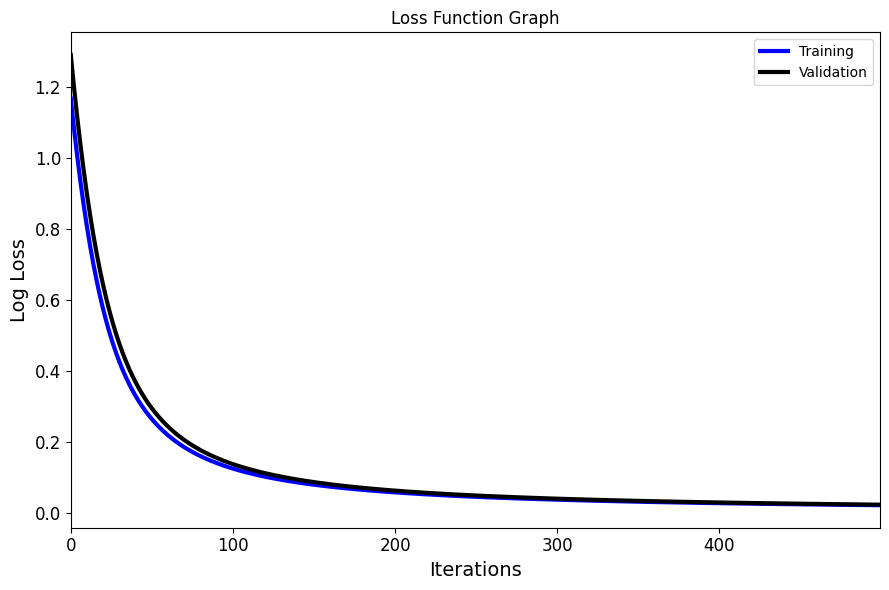

In [78]:
#@title Run this cell to produce the Loss Function Visualization Graphs
fig, ax = plt.subplots(figsize=(9,6), dpi=100)
ax.plot(losses[0], color='blue', label='Training', linewidth=3);
ax.plot(losses[1], color='black', label='Validation', linewidth=3);
ax.legend();
ax.set_ylabel('Log Loss')
ax.set_xlabel('Iterations')
ax.set_title('Loss Function Graph')
ax.autoscale(axis='x', tight=True)
fig.tight_layout();

In [79]:
# Let's get predictions from our model for the training, validation, and testing
# datasets
y_hat_train = (predict_function(X_train, coeffs)>=.5).astype(int)
y_hat_valid = (predict_function(X_valid, coeffs)>=.5).astype(int)
y_hat_test = (predict_function(X_test, coeffs)>=.5).astype(int)

y_sets = [ [y_hat_train, y_train],
           [y_hat_valid, y_valid],
           [y_hat_test, y_test] ]

def accuracy_score(y_hat, y):
    assert(y_hat.size==y.size)
    return (y_hat == y).sum()/y.size
accuracies=[]
[accuracies.append(accuracy_score(y_set[0],y_set[1])) for y_set in y_sets]

printout= (f'Training Accuracy:{accuracies[0]:.1%} \n'
           f'Validation Accuracy:{accuracies[1]:.1%} \n'
           f'Test Accuracy:{accuracies[2]:.1%} \n')

# Add the testing accuracy only once you're sure that your model works!
print(printout)

Training Accuracy:100.0% 
Validation Accuracy:100.0% 
Test Accuracy:100.0% 



Congratulations on training a logistic regression algorithm from scratch!

Your loss function graph should look something similar to this...
<img src='https://unils-my.sharepoint.com/:i:/g/personal/tom_beucler_unil_ch/EUqSnwtsU7VEkUul4oqhj6cBy1FIGMsGAfTXTmXQke1N3g?download=1'>

And the accuracies we got during development of the notebook are:

`Training Accuracy:99.4%`  <br>
`Validation Accuracy:100.0%` <br>
`Test Accuracy:100.0% `

Once you're done with the upcoming environmental science applications notebook, feel free to come back to take a look at the challenges 😀

## Challenges

* **C1)** Add more features to try to improve our accuracies!

* **C2)** Add early stopping to the training algorithm! (e.g., stop training when the accuracy is greater than a target accuracy)